# 【第３回 課題3】 画像生成: Generative Adversarial Network (GAN)　

In [1]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # IEDの場合，必要に応じて指定(0-7)．未指定時はランダムに割り当てられる．

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

using GPU: 7
Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# This code is based on https://github.com/jason71995/Keras-GAN-Library
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, ReLU
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

Using TensorFlow backend.


## 画像生成・変換ネットワーク

ニューラルネットワークは，画像認識だけでなくて，これまでの課題で，DeepDream, Style Transferなどのように画像を出力することもできました．ただし，これらの課題での方法は，ネットワークパラメータの代わりに画像自体を最適化して，画像変換を実現するというもので，1000種類画像認識データで学習済の画像認識ネットワークを，通常の認識とは異なる特別な使い方をして画像生成を行ったものでした．どちらも最適化を画像に対して行なうので，ネットワークの学習時と同じ様に画像の生成に繰り返しの最適化計算が必要となって，時間が掛かる難点がありました．

一方，前回，課題４でやったように画像認識は，ネットワークに画像を入力すると，一瞬で答えが出ます．

実は，同じ様に，画像の元となるベクトル(seed)を入力すると，そのベクトルに応じた画像を一瞬で出力するネットワークや，画像を入力すると変換された画像を一瞬で出力するネットワークも構築することが可能です．（実は前回の課題２で，画像を入力して，画像を出力する，エッジ抽出ネットワークを学習していました．それを deepにすると，もっと複雑な変換が可能となります．)

下図に示すように，以下のネットワークが実現可能です．どれも一度データを入力すると，瞬時に出力結果が得られます．

1. 画像を入力したら低次元ベクトルを出力するネットワーク：　エンコーダー型ネットワーク (encoder) ．画像認識ネットワーク．
1. 低次元ベクトルを入力すると画像を出力するネットワーク：　デコーダー型ネットワーク (decoder)．画像生成ネットワーク．
1. 画像を入力すると，エンコード，デコードを行って，異なる画像に変換して出力するネットワーク: エンコーダ・デーコーダ型ネットワーク (encoder-decoder)．画像変換ネットワーク．

<img src="fig/networks.png" width=600>

課題3では，画像生成ネットワークについて，実験を行います．なお，課題4,5では，画像変換ネットワークについて実験を行います．

## 画像生成

では，ここでは画像生成について簡単に説明します．画像生成ネットワークを以下に示します．

<img src="fig/gan.png" with=600>

認識ネットワーク(encoder netowrk)は特徴マップのサイズが徐々に縮小していきましたが，生成ネットワーク(decoder network)では特徴マップが徐々に拡大していきます．

畳み込みの説明で，特徴マップサイズを縮小するために，strideが2以上の畳み込み層，もしくは max/average pooling層を使う，と説明しました．では，逆に拡大するにはどうすればいいでしょうか？

Stride>=2の畳み込みの演算を逆に行なう「転置畳み込み (transposed covolution)(deconvolutionと呼ぶときもあります)」，もしくは 通常のpoolingの逆の「 unpooling」操作を行なうことで実現できます．(1) 転置畳み込みをもちいると，通常はstride=2の畳み込みの逆伝搬時の演算を順伝搬時に行なうことで，逆の変換が行われて，特徴マップのサイズが縦横2倍づつになります． (2) Unpoolingでは，学習パラメータなしに，1つのピクセルを 2x2のピクセルに拡大します．その時に，元の値を4箇所にコピーする方法と左上の1箇所のみコピーする方法があります．

実験では，Kerasに用意された，Conv2DTranspose を利用します．ちなみに，行列の微分が転置行列(transpose)になるために逆伝搬の計算では重み行列の転置行列を掛けることになることより，畳み込み層を逆に使った場合の操作は「転置畳み込み」と呼ばれています．


## 敵対学習

次に，decoderネットワークの学習です．

認識ネットワークでも，エッジ抽出ネットワークでも，ネットワークの学習には，入力と出力のペアになった学習データが必要でした．

画像生成の場合は，実は，入力のランダムベクトルは，本当にランダムで構いません．以下の実験では．正規分布に従う乱数で各要素の値を決めた100次元ランダムベクトルを各学習画像に割り当てて，入力ベクトルと画像のペアを作って学習します．(正確にはepoch毎に違うベクトルを割り当てています．)

入力と出力のペアがあれば，最小２乗誤差(mean_squared_error)で評価して，それを最小化することによって学習できそうですが，一般には学習が難しく，学習できたとしてもぼやけた画層しか生成できないとされています．(来年はその実験も追加します．)

一般に画像生成ネットワークの学習には，敵対的ネットワーク (Generative Adversarial Network, GAN) を用いた学習を行います．敵対的ネットワークの枠組みでは，以下の図に示すように，生成ネットワーク(generator)に加えて，判別ネットワーク(discriminator)を用意し，お互いを競わせて学習していくことによって，本物に近い画像を生成するネットワークの学習が可能になります．

<img src="fig/gan2.png" width=600>

敵対学習の目的は，生成画像の分布を学習画像の分布に近づけるようにすることです．初期に提案された DCGAN (Deep Convolutional GAN)と呼ばれる方法では，2つのネットワークを競わせる敵対学習が，生成分布と学習データ分布の JS Diivergenceを最小化していることと等価であることが示されています．

<img src="fig/gan3.png" width=600>

敵対的ネットワーク (Generative Adversarial Network, GAN)は，その頭文字から　GAN（日本では「ガン」と発音する人が多いが，国際的には「ギャン」が普通） と呼ばれ，深層学習研究のホットトピックになっています．

GANは画像生成のみならず，画像変換でも利用されています．課題4,5では，GANを用いた画像変換を実験します．

### Kerasによる GANの実験

GANは２つのネットワークを敵対させて学習させるため，学習が難しいとされています．どちらか一方が早く学習してしまうと，もう一方のネットワークが学習することができず，学習が進まなくなることがあります．例えば，同じ画像ばかりが生成されたり，砂嵐のようなランダム画像が生成されるようになったりすることはよくあります．

ここでは，学習が容易で，学習速度も速いと言われる最新の[SN-GAN](https://arxiv.org/abs/1802.05957)(Spectral Normalization Generative Adversarial Networks)を使って，画像生成ネットワークの学習実験を行ってみます．






## 学習データ

画像生成実験用に，食事画像データセットを23種類各1000枚をIED/CEDに用意しました．

食事23種類 

bibimba, chahan, chikenrice, curry, ebichill, gratin, gyudon, hiyachu, kaisendon, katsudon, meatspa, omelet, omurice, oyakodon, pilaf, pizza, ramen, rice, soba, steak, tendon, unadon, yakisoba

IED: /usr/local/class/object/media/foodimg{64,96,128,256}/{食事カテゴリ名}/

CED: /ced-home/staff/yanai/media/foodimg{64,96,128,256}/{食事カテゴリ名}/

img0000.jpg ... img0999.jpg : 食事画像 

hed0000.png...hed0999.png : 食事画像の輪郭線画像


学習用の画像の解像度は, 64x64, 96x96, 128x128, 256x256の4通りです．基本は最も小さい64x64でいいですが，時間が掛かっても，より高解像度の画像で試してみたい人は，96, 128, 256 も試してみてください．当然ですが，解像度が高ければ高いほど学習時間は掛かります．（深層学習を使った研究では，寝る前に学習を始めて，朝確認してみる，というのが日課になっている人も多いですね．．．）


### パラメータの設定

画像サイズ img_size，食事カテゴリ(23種類の中から選ぶ), ランダムベクトルの次元，学習エポック数，バッチサイズなどを設定します．

outdir は学習途中で生成された画像と学習したパラメータの保管場所です．

In [4]:
img_size= 64
food = "kaisendon" 

latent_dim = 128

epochs = 500
batch_size= 64

outdir='result/gan1'
os.makedirs(outdir, exist_ok=True)

In [5]:
# generator (画像生成ネットワーク)　の定義
# 100次元のランダムベクトルを受け取って，それに対応した96x96の画像を出力

# 最初の featuremap size 64x64 -> 4,  96x96 -> 6, 128x128 -> 8  とする．
if img_size==64:
  init_fm_size=4 
elif img_size==96:
  init_fm_size=6
elif img_size==128:
  init_fm_size=4
elif img_size==256: 
  init_fm_size=8
else:
  raise ValueError("Img size error!")

def build_generator(latent_dim,init_fm_size):
    model = Sequential()
    model.add(Dense(512 * init_fm_size * init_fm_size, activation="relu", input_shape=(latent_dim,)))
    model.add(Reshape((init_fm_size, init_fm_size, 512)))
    if img_size>=128:  # 128以上のときは，生成ネットワークのレイヤーを増やす
        model.add(Conv2DTranspose(512,(3,3),strides=(2,2),padding="same"))
        model.add(LeakyReLU(0.1))
        
    model.add(Conv2DTranspose(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2DTranspose(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2DTranspose(32,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2D(3,(3,3),padding="same",activation="tanh"))
    return model
    
gen=build_generator(latent_dim, init_fm_size)
gen.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         1179904   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_______________________________________

In [6]:
# discriminator (判別ネットワーク) の定義
# discriminator は，本物(real) / 偽物(fake) の判定を行います．
# SN-GAN では，Spectral Normalization 付きの Conv2Dを使います．
# SNConv2D.py が必要です．

from SNConv import SNConv2D
def build_discriminator(input_shape):
    model = Sequential()

    model.add(SNConv2D(64,(3,3),strides=(2,2),padding="same",input_shape=input_shape))
    model.add(LeakyReLU(0.1))

    model.add(SNConv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))

    model.add(SNConv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))

    model.add(SNConv2D(512,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(0.1))

    if img_size>=128: 
        model.add(SNConv2D(1024,(3,3),strides=(2,2),padding="same"))
        model.add(LeakyReLU(0.1))
    
    model.add(SNConv2D(1,(3,3),padding="same"))
    model.add(GlobalAveragePooling2D())

    return model

disc=build_discriminator((img_size,img_size,3))
disc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sn_conv2d_1 (SNConv2D)       (None, 32, 32, 64)        1856      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
sn_conv2d_2 (SNConv2D)       (None, 16, 16, 128)       73984     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
sn_conv2d_3 (SNConv2D)       (None, 8, 8, 256)         295424    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
sn_conv2d_4 (SNConv2D)       (None, 4, 4, 512)        

In [7]:
# placeholder をつかって，最適化する関数を記述します．
# tensorflow の機能を使っています．理解不要です．

noise = K.random_normal((batch_size,) + (latent_dim,),0.0,1.0,"float32")
real_image = K.placeholder((batch_size,) + (img_size,img_size,3))
fake_image = gen(noise)

pred_real = disc(real_image)
pred_fake = disc(fake_image)

d_loss = K.mean(K.maximum(0., 1 - pred_real)) + K.mean(K.maximum(0., 1 + pred_fake))
g_loss = -K.mean(pred_fake)

# get updates of W_u in SNConv2D layers
d_updates = disc.get_updates_for([K.concatenate([real_image,fake_image],axis=0)])
d_training_updates = Adam(lr=0.0001, beta_1=0.0, beta_2=0.9).get_updates(d_loss, disc.trainable_weights)
d_train = K.function([real_image, K.learning_phase()], [d_loss],d_updates + d_training_updates)

g_training_updates = Adam(lr=0.0001, beta_1=0.0, beta_2=0.9).get_updates(g_loss, gen.trainable_weights)
g_train = K.function([K.learning_phase()], [g_loss], g_training_updates)

In [8]:
# preparing a training image list
import glob
imglist=glob.glob(datadir+'foodimg%d/%s/img*.jpg' % (img_size,food))
imglist=[datadir+'foodimg%d/%s/img%04d.jpg' % (img_size,food,n) for n in range(1000)]
num=len(imglist)

In [9]:
# ramen, curry など23種類あります．
a=glob.glob(datadir+'foodimg%d/pizza/*.jpg' % img_size)
print("num training image: ",num, len(a))

num training image:  1000 1000


In [10]:
def preprocess_input(x):
    # rescale -1 to 1
    return (x/127.5-1.0).astype('float32')

In [11]:
# reading training images
imgs = np.empty((num*2,img_size,img_size,3), np.float32)
for i, img_path in enumerate(imglist):
    if i%100==0:
        print("reading {}th image".format(i))
    img = image.load_img(img_path, target_size=(img_size, img_size))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    imgs[i*2]   = x
    imgs[i*2+1] = x[::-1,:,:] # horizontal flip
num=num*2
print(imgs.shape,num)

reading 0th image
reading 100th image
reading 200th image
reading 300th image
reading 400th image
reading 500th image
reading 600th image
reading 700th image
reading 800th image
reading 900th image
(2000, 64, 64, 3) 2000


In [12]:
%matplotlib inline
from IPython import display

def save_imgs(epoch,save):
     r, c = 4, 10
     noise = np.random.normal(0, 1, (r * c, latent_dim))
     gen_imgs = gen.predict(noise)  
        
     idx = np.random.randint(0, imgs.shape[0], 10)
     gen_imgs[0:10] = imgs[idx]
  
     fig, axs = plt.subplots(r, c, figsize=(16,6))
     cnt = 0
     for i in range(r):
         for j in range(c):
             axs[i,j].imshow(image.array_to_img((gen_imgs[cnt]+1.0)*127.5),vmin=0,vmax=255)
             axs[i,j].axis('off')
             cnt += 1
     if save==0:
         fig.savefig(outdir+"/%04d.png" % epoch)
                  
     display.clear_output(wait = True)
     display.display(fig)
     plt.close()

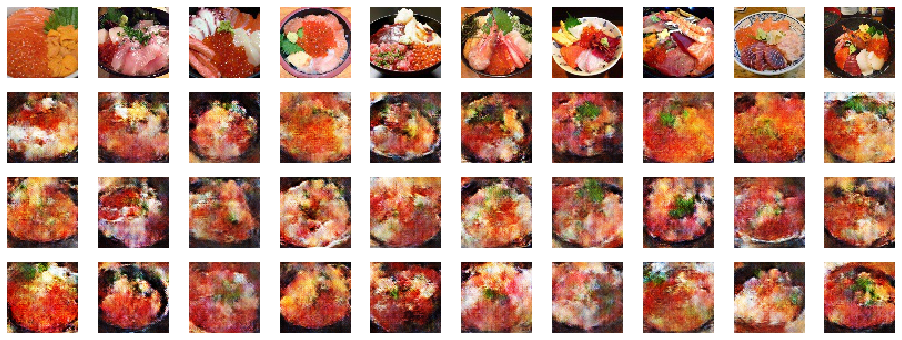

496 [D loss: 0.005035] [G loss: 3.185071] (979 sec)      
497 [D loss: 0.015750] [G loss: 3.560678] (981 sec)      
498 [D loss: 0.000364] [G loss: 4.361884] (982 sec)      
499 [D loss: 0.358158] [G loss: 2.074429] (984 sec)      
epoch: 499  time: 984 sec


In [13]:
# 学習ループ本体．
import time
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

start=time.time()

for epoch in range(epochs):
    idx = np.random.permutation(num)
    for step in range(num//batch_size):

        real_imgs = imgs[idx[step*batch_size:(step+1)*batch_size]]

        d_loss, = d_train([real_imgs, 1])
        g_loss, = g_train([1])
    
    print ("%d [D loss: %f] [G loss: %f] (%d sec)      \r" % (epoch, d_loss, g_loss, time.time()-start),)

    if epoch % 5==0:
      save_imgs(epoch, epoch % 50)
tm=time.time()-start

print("epoch: %d  time: %d sec" % (epoch, tm))

In [14]:
gen.save(outdir+'/gen_%s.h5' % food)
disc.save(outdir+'/disc_%s.h5' % food)
print("saved the models as '%s/gen_%s.h5' and '%s/disc_%s.h5'" % (outdir,food,outdir,food))

saved the models as 'result/gan1/gen_kaisendon.h5' and 'result/gan1/disc_kaisendon.h5'


## 課題3

以下の小問の(1)(2)を解答せよ．**(課題提出には解答シートを使って下さい．)**

1. 23種類の中から好きな料理を選んで学習してみよ．(サンプルの海鮮丼以外がよい) 30分程度掛かる．
1. 学習できたモデルを用いて，連続変化の画像を生成せよ．以下のようにランダムベクトルを生成し，その間を補完して，画像を連続生成すればよい．さらに，ffmpegコマンドを利用して連番の画像から動画を生成することができる．連続変化動画を作成してみよ．(動画は提出しなくて良い．)

【mp4】ffmpeg -y -framerate 15 -i result/gan1/img_%04d.png -vcodec libx264 -pix_fmt yuv420p -r 60 result/gan1/gan_movie.mp4

なお，課題3, 4, 5 に共通するが，ある程度きれいな画像が生成できるようになったら，途中でinterruput して，それを最終結果としてよい．
逆に，最初に設定されている epoch数を学習しても，きれいな画像が生成できない場合は，epoch数を増やして学習してみよ．epoch数を増やして最初から実行する以外に，学習ループのセルのみを繰り返し実行すれば，学習済のパラメータがモデルに残っているので，続きを学習することが可能である．ただし，GPUメモリを開放してしまうと，当然であるが，続きからの学習はできない．

/usr/local/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


generated 300 images


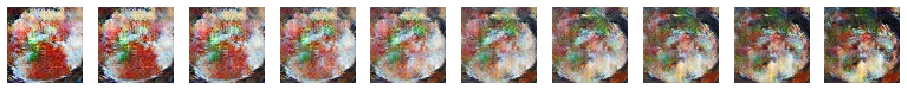

In [15]:
## save したモデルを読み込んで，連続変化画像の生成
## 以下の３つのセルを実行すれば，連続変化動画が生成できる．

from keras.models import load_model
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

gen = load_model(outdir+'/gen_%s.h5' % food)

pn=10
pt=np.random.normal(0, 1, (pn+1, latent_dim))
pt[pn]=pt[0]
steps=30
no=0
r, c = 1, 10

for p in range(pn):
  start=pt[p]
  end=pt[p+1]
  step =(end-start)/steps
  inputs = np.empty((0,latent_dim), float)
  for j in range(steps):
      inputs = np.vstack((inputs,start+step*j))
  gen_imgs = gen.predict(inputs)  
  gen_imgs = (gen_imgs + 1.0) * 127.5        
  for j in range(steps):
      image.array_to_img(gen_imgs[j]).save(outdir+'/img_%04d.jpg' % no)
      no=no+1
        
print("generated %d images" % no)
fig = plt.figure(figsize=(16,4))
for j in range(c):
    ax = fig.add_subplot(r,c,j+1)
    ax.imshow(image.array_to_img(gen_imgs[j*3]),vmin=0,vmax=255)
    ax.axis('off')


In [16]:
!/usr/local/anaconda3/bin/ffmpeg -y -framerate 15 -i result/gan1/img_%04d.jpg -vcodec vp8 -r 60 result/gan1/gan_movie.webm

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 7.2.0 (crosstool-NG fa8859cb)
  configuration: --prefix=/usr/local/anaconda3 --cc=/opt/conda/conda-bld/ffmpeg_1531088893642/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, image2, from 'result/gan1/img_%04d.jpg':
  Duration: 00:00

In [17]:
# 以下を実行すれば，JupyterNotebook内で動画再生できる．
import io
import base64
from IPython.display import HTML

video = io.open('result/gan1/gan_movie.webm', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="gan_movie" width=128 autoplay loop>
                <source src="data:video/webm;base64,{0}" type="video/webm" />
             </video>'''.format(encoded.decode('ascii')))

In [18]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()